# Value at Risk (VaR) Analysis

In this notebook we compute one-period VaR (e.g. 1-minute) at common confidence levels using three approaches:
- **Historical VaR** (non-parametric quantile of empirical returns)
- **Parametric VaR** (assuming normal returns)
- **Monte Carlo VaR** (simulating from estimated normal distribution)

In [ ]:
# 1) Imports & settings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8')

# confidence level for VaR
alpha = 0.05  # 95% VaR


In [ ]:
# 2) Load data & compute simple returns
path = '/Users/mchildress/Active Code/ts_basics/data/bnbusdt_1m.csv'
df = pd.read_csv(path, parse_dates=True)
if 'timestamp' in df.columns:
    df.set_index('timestamp', inplace=True)

# 'close' price column
df['ret'] = df['close'].pct_change().dropna()
returns = df['ret'].dropna()

# quick stats
returns.describe().round(6)

count    3.675431e+06
mean     2.000000e-06
std      1.466000e-03
min     -9.810200e-02
25%     -4.670000e-04
50%      0.000000e+00
75%      4.780000e-04
max      1.124270e-01
Name: ret, dtype: float64

## 3) Historical VaR
The α-VaR is simply the empirical α-quantile of the return distribution. Meaning, the worst return expected in 100% of all minutes.

In [3]:
hist_VaR = np.quantile(returns, alpha)
print(f"Historical VaR at {100*(1-alpha):.1f}% confidence: {hist_VaR:.5%}")

Historical VaR at 95.0% confidence: -0.19014%


## 4) Parametric VaR (Normal)
Assume returns ~ N(μ, σ²). Then VaR = μ + σ·zₐ where zₐ is the α-quantile of standard normal. Meaning, the loss (or return) threshold which, under a normal model, would only breach α % of the time

In [4]:
mu, sigma = returns.mean(), returns.std()
z = np.quantile(np.random.standard_normal(1_000_000), alpha)
param_VaR = mu + sigma * z
print(f"Parametric VaR at {100*(1-alpha):.1f}% confidence: {param_VaR:.5%}")

Parametric VaR at 95.0% confidence: -0.24094%


## 5) Monte Carlo VaR
Simulate a large number of returns from N(μ, σ²) and take the α-quantile. Meaning the following: your returns behave like a bell curve with average μ and “spread” σ, randomly draw 100,000 possible returns from that bell curve, sort from best to worst, and then pick the percentile value (5th percentile for 5% VaR) --- that’s the return level which only α % of simulated outcomes fall below. Random sampling to to estimate the threshold loss.

In [ ]:
n_sims = 200_000
sim_rets = np.random.normal(loc=mu, scale=sigma, size=n_sims)
mc_VaR = np.quantile(sim_rets, alpha)
print(f"Monte Carlo VaR at {100*(1-alpha):.1f}% confidence: {mc_VaR:.5%}")

Monte Carlo VaR at 95.0% confidence: -0.24108%


## 6) Plot return distribution and VaR levels

Text(0, 0.5, 'Density')

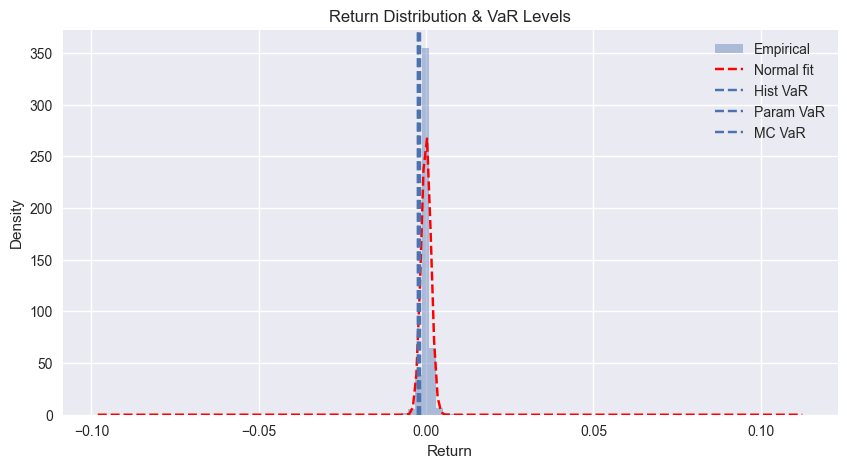

In [6]:
plt.figure(figsize=(10,5))
# empirical histogram
plt.hist(returns, bins=100, density=True, alpha=0.4, label='Empirical')
# overlay normal pdf
x = np.linspace(returns.min(), returns.max(), 200)
plt.plot(x, 1/(sigma*np.sqrt(2*np.pi)) * np.exp(-0.5*((x-mu)/sigma)**2), 'r--', label='Normal fit')

# VaR lines
for qty, label in [(hist_VaR, 'Hist VaR'), (param_VaR, 'Param VaR'), (mc_VaR, 'MC VaR')]:
    plt.axvline(qty, linestyle='--', label=label)

plt.legend(); plt.title('Return Distribution & VaR Levels'); plt.xlabel('Return'); plt.ylabel('Density')


## 7) Summary
- **Historical VaR**: non-parametric, directly from data.
- **Parametric VaR**: fast, but relies on normality assumption.
- **Monte Carlo VaR**: flexible, can simulate more complex dynamics.

All three should give similar numbers if returns are near-normal, but historical and Monte Carlo can capture fat-tails better.